In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import pandas as pd
import numpy as np

from sklearn import datasets

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score
from prettytable import PrettyTable

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer 
import category_encoders

from sklearn.metrics import r2_score

## Preprocessing

In [2]:
def loadData(directory):
    df = pd.read_csv(directory,sep="\t")
    return df

def getSentimentLabel(X): 
    avg = np.mean(X['quality'])
    X['sentiment'] = X['quality'].apply(lambda x: np.min([2,int(x/30)]))
    
    return X
    
## BinatyEncoding
def doPreproc(X_d,X_e,labels):
       
    df = pd.concat([X_d,X_e])

    encoder = category_encoders.BinaryEncoder(cols=labels)
    df = encoder.fit_transform(df)
    
    ev = df[df['quality'].isna()].drop(columns=['quality'])
    dev = df.dropna(subset=['quality'])

    return dev, ev

In [3]:
## LOADING - ENCODING - SENTIMENT LABELING
X_dev = loadData('Dataset/dev.tsv')
X_eval = loadData('Dataset/eval.tsv')
X_dev = X_dev.drop_duplicates()
X_dev = X_dev.drop(columns=['region_2'])
X_eval = X_eval.drop(columns=['region_2'])


X_prep_v, X_eval_v = doPreproc(X_dev,X_eval,['country','province','variety',
                                                  'winery','region_1','designation'])

X_prep_v = getSentimentLabel(X_prep_v)

## Sentiment Analysis

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords as sw
import Stemmer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [6]:
def doLogisticRegression(x,y):
    
    model = LogisticRegression(max_iter=10000)
    
    parameters ={
        'C':np.logspace(-3,3,7), 
        'penalty':["l1","l2"], # l1 lasso l2 ridge
        'random_state' : [42],
        'n_jobs' : [-1]
    } 
    
    gs = GridSearchCV(estimator=model,  
                         param_grid=parameters,
                         scoring='accuracy',
                         cv=5,
                         n_jobs=-1)

    gs.fit(x, y)
    print("\nLOGISTIC REGRESSION: ")
    print(f"Best parameters = {gs.best_params_}")
    print(f"Best score = {gs.best_score_ }")
    
    return gs

In [7]:
def doMultinomialNB(x,y):
    
    model = MultinomialNB()
    
    parameters =  {
        'alpha': np.linspace(0.5, 1.5, 6),
        'fit_prior': [True, False]
    }
    
    gs = GridSearchCV(estimator=model,  
                         param_grid=parameters,
                         scoring='accuracy',
                         cv=5,
                         n_jobs=-1)

    gs.fit(x, y)
    print("\nMULTINOMIAL NB: ")
    print(f"Best parameters = {gs.best_params_}")
    print(f"Best score = {gs.best_score_ }")
    
    return gs

In [8]:
def doSGDClassifier(x,y):
    
    model = SGDClassifier(max_iter=1000)
    
    parameters =  {
        "loss" : ["hinge", "log","squared_hinge", "modified_huber"],
        "alpha" : [0.0001, 0.001, 0.01, 0.1],
        "penalty" : ["l2", "l1", "none"],
        "n_jobs" : [-1],
        "random_state" : [42]
    }
    
    gs = GridSearchCV(estimator=model,  
                         param_grid=parameters,
                         scoring='accuracy',
                         cv=5,
                         n_jobs=-1)

    gs.fit(x, y)
    print("\nSGDClassifier: ")
    print(f"Best parameters = {gs.best_params_}")
    print(f"Best score = {gs.best_score_ }")
    
    return gs

In [5]:
a = list(X_eval['description'].values) 
b = list(X_dev['description'].values)

X_sentiment = a + b
y_sentiment_train = X_prep_v['sentiment']

stop_words_list = sw.words('english') + ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would']

In [6]:
tfidf_naive = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None, 
                              stop_words=stop_words_list, ngram_range=(1,2))

X_tfidf = tfidf_naive.fit_transform(X_sentiment)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf[:X_dev.shape[0]], y_sentiment_train, test_size=0.25, random_state=42)

In [8]:
model = SGDClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.7826127863762525


In [9]:
from collections import Counter
Counter(y_pred)

Counter({1: 21257})

In [29]:
#

# gs_SGDClassifier = doSGDClassifier(X_naive_complete[:X_dev.shape[0]],y_sentiment_train)

params = {
    "loss" : ["hinge", "log","squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"],
    "n_jobs" : [-1],
    "random_state" : [42]
}

model = SGDClassifier(max_iter=1000)
clf = GridSearchCV(model, param_grid=params, n_jobs=-1, scoring='accuracy',cv=5)
clf.fit(X_tfidf[:X_dev.shape[0]], y_sentiment_train)
print(clf.best_score_)

0.7791080588918529


In [ ]:
#clf_LR = doLogisticRegression(X_tfidf[:X_dev.shape[0]], y_sentiment_train)
#clf_MNB = doMultinomialNB(X_tfidf[:X_dev.shape[0]], y_sentiment_train)

In [11]:
model_final = SGDClassifier()
model_final.fit(X_tfidf[:X_dev.shape[0]], y_sentiment_train)
sentiment_predicted = model_final.predict(X_tfidf[X_dev.shape[0]:])

In [12]:
X_eval_v['sentiment'] = sentiment_predicted

## Model selection
\# -- specificare la misura di riferimento (accuracy o altro) <br /><br />
In order to tune the best models, we tested #tot different classifiers with their default hyperparameters through the Repeated K-Fold Cross Validation. This gives a more “robust” model assessment score rather than the fairly well known K-Fold Cross Validation, because it run several times. In this case we used 5 folds and 10 ierations. The algorithms that we tested are: 
- **
- **

The output of the the Cross Validation phase can be clearly seen in Figure # . So we decided to tune the \\ and the \\ classifiers trough the Grid Search, as explained in the next section. 

In [136]:
def evaluateModels(models, targets,X,y):
    
    scores = pd.DataFrame()
    
    for model,target in zip(models,targets):
        cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)
        scores[target] = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
        
    return scores

Text(0, 0.5, 'R2_Score')

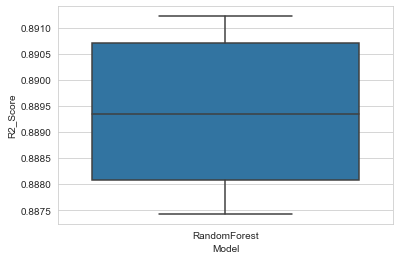

In [137]:
randomforest = RandomForestRegressor()
models = [randomforest]
targets = ["RandomForest"]


scores = evaluateModels(models,targets,X,y)
sns.boxplot(x="variable", y="value", data=pd.melt(scores))
plt.xlabel("Model")
plt.ylabel("R2_Score")

## Hyperparameter tuning
In order to improve the performances of the selected models we used the GridSearchCV that performs a Cross Validation over all the combinations of a given set of hyperparameters. Since we had enough data, we used the hold out technique, so we considered 80% for the train data and the remaining 20% for the testing the models. 

## Results
The results of the hyperparameters tuning can be seen in Table ##. Apparently they all outperformed their naive solutions and \[brodo\] 

In [17]:
y = X_prep_v.quality
X = X_prep_v.drop(columns=['quality','description'])

In [29]:
def doGridSearch(model,model_name,hyperparams,X,y):
    gs = GridSearchCV(estimator=model,  
                         param_grid=hyperparams,
                         scoring='r2',
                         cv=4,
                         n_jobs=6,
                         verbose=True)

    gs.fit(X, y)
    return gs

In [43]:
hyperparams_RF = {
    "n_estimators": [800],
    #"criterion": ["mse", "mae"],
    "max_features": ["auto"],
    #"max_features": ["auto", "sqrt", "log2"],
    "random_state": [42],# always use the samet random seed
    "n_jobs": [-1],# for parallelization
}

In [104]:
X.shape, y.shape

((85028, 72), (85028,))

In [44]:
gs_800 = doGridSearch(RandomForestRegressor(verbose=True), "RandomForestRegressor",hyperparams_RF,X.drop(columns=['sentiment']),y)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   4 out of   4 | elapsed:  8.2min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  2.7min finished


In [45]:
print(f"Best params:\t{gs_800.best_params_}")
print(f"Best score:\t{gs_800.best_score_}")

Best params:	{'max_features': 'auto', 'n_estimators': 800, 'n_jobs': -1, 'random_state': 42}
Best score:	0.6517462560340501


In [39]:
X.drop(columns=['sentiment']).shape, X_eval_v.drop(columns=['description','sentiment']).shape

((85028, 71), (30186, 71))

## Deploy

In [40]:
y_pred  = gs_700.predict(X_eval_v.drop(columns=['description','sentiment']))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    1.9s finished


In [41]:
def get_csv(ids, y):
    pd.DataFrame(dict(Id = ids,Predicted = y)).to_csv("submission6.csv",sep=",",index=False)

In [42]:
get_csv(list(X_eval.index),y_pred)

## Deploy history

### Submission 1 : 0.756 | 2021-01-11 16:24:05.639162 	
* Preprocessing: hash <br />
* Model : Random Forest <br />
* Hyperparams: {'max_features': 'sqrt', 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42} <br />
* features : country,province,region_1, variety, winery, length_description <br />

### Submission 2 : 0.807 | 2021-01-12 08:14:14.977122	
* Preprocessing: hash <br />
* Model : Random Forest <br />
* Hyperparams: {'max_features': 'auto', 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42}
* features : country,province,region_1, variety, winery, designation <br />

### Submission 3 : 0.822 | 2021-01-12 08:56:40.440284
* Preprocessing: BinaryEncoding <br />
* Model : Random Forest <br />
* Hyperparams: {'max_features': 'auto', 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42}
* features : country,province,region_1, variety, winery, designation <br />

### Submission 5 : 0.512 | 2021-01-13 09:24:57.953673
* Preprocessing: BinaryEncoding + Sentiment Analysis <br />
* Model : Random Forest Regressor + SGDClassifier <br />
* Hyperparams: {'max_features': 'auto', 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42}
* features : country,province,region_1, variety, winery, designation, sentiment <br />
* sentiment : X['sentiment'] = X['quality'].apply(lambda x: np.min([2,int(x/30)]))

### Submission 6 : 0.822 | 2021-01-13 09:45:30.360426
* Preprocessing: BinaryEncoding <br />
* Model : Random Forest <br />
* Hyperparams: {'max_features': 'auto', 'n_estimators': '700', 'n_jobs': -1, 'random_state': 42}
* features : country,province,region_1, variety, winery, designation <br />

## //Test